In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from typing import List, Dict
from CommonFunctions import *
%matplotlib inline

In [3]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 0.001
    epochs: int = 150
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')
    dropout: float = 0.3
    batch_norm: bool = True
PARAMS = LearningParameters()

def load_dataset(path, transform, subset=None, download=False):
    train_data = datasets.CIFAR10(root=path, 
                                  train=True, 
                                  download=download, 
                                  transform=transform)
    test_data = datasets.CIFAR10(root=path, 
                                 train=False,
                                 download=download, 
                                 transform=transform)
    if subset is not None:
        train_data = Subset(train_data, range(subset[0]))
        test_data = Subset(test_data, range(subset[1]))
    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=PARAMS.batch_size,
                                  shuffle=True,
                                  pin_memory=True)
    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=PARAMS.batch_size,
                                 shuffle=False,
                                 pin_memory=True)
    return train_data, test_data, train_dataloader, test_dataloader

class ModularVGG(nn.Module):
    """
    VGG model that can be extended freely
    """
    def __init__(self, input_layer_size: int, num_of_classes: int, image_size: int, config: Dict):
        super(ModularVGG, self).__init__()
        self.latest_layer_size = input_layer_size
        self.image_size = image_size
        
        self.conv_layer = nn.Sequential(
            *self._conv_layers(**config['CONV']),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            *self._linear_layers(**config['FC']),
            nn.Linear(in_features=self.latest_layer_size,
                      out_features=num_of_classes),
            nn.Softmax(dim=1)
        )
        
        self.initialize_weights()
        
    def _conv_layers(self, conv_layers: List[List[int]],
                           kernel_params: Dict,
                           batch_norm: bool = False,
                           activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for conv_layer in conv_layers:
            for out_channels in conv_layer:
                layers += [nn.Conv2d(in_channels=self.latest_layer_size,
                                     out_channels=out_channels, **kernel_params), activation]
                self.latest_layer_size = out_channels
            layers += [nn.MaxPool2d(kernel_size=2)]
            layers += [nn.BatchNorm2d(num_features=self.latest_layer_size)] if batch_norm else []
        self.latest_layer_size = (self.image_size // 2**len(conv_layers))**2 * self.latest_layer_size
        return layers
                
    
    def _linear_layers(self, layer_sizes: List[int],
                             dropout: float = 0.,
                             activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for layer_size in layer_sizes:
            layers += [nn.Dropout(p=dropout)] if dropout > 0 else []
            layers += [nn.Linear(in_features=self.latest_layer_size,
                                 out_features=layer_size), activation]
            self.latest_layer_size = layer_size
        return layers
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_layer(x))

def accuracy(y_pred, y_true):
    return (y_true == y_pred).sum().item() / len(y_pred)

def train_step(model, dataloader, criterion, accuracy_function, optimizer, device):
    train_loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= (data_len := len(dataloader))
    accuracy /= data_len
    return train_loss, accuracy

def test_step(model, dataloader, criterion, accuracy_function, device):
    test_loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = criterion(test_pred, y)
            test_loss += loss.item()
            accuracy += accuracy_function(test_pred.argmax(dim=1), y)
        test_loss /= (data_len := len(dataloader))
        accuracy /= data_len
    return test_loss, accuracy

def plot_loss_and_accuracy(title, epochs, loss_dict, accuracy_dict, file):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        x_axis = range(1, epochs + 1)
        for loss_type, loss in loss_dict.items():
            axes[0].plot(x_axis, loss, label=f'{loss_type}: {min(loss):.3f}')
        axes[0].set(ylabel='Loss', title=title)
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        for accuracy_type, accuracy in accuracy_dict.items():
            axes[1].plot(x_axis, accuracy, label=f'{accuracy_type}: {max(accuracy):.3f}')
        axes[1].set(ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
        figure.savefig(f'images/{file}.png')
        return figure, axes

In [4]:
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
vgg_cfg = dict(
    vgg11=dict(
        CONV=dict(
            conv_layers=[[64],
                         [128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg13=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg16=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256],
                         [512, 512, 512],
                         [512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg19=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256, 256],
                         [512, 512, 512, 512],
                         [512, 512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg22=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256, 256, 256],
                         [512, 512, 512, 512, 512],
                         [512, 512, 512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ) 
)

transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = ModularVGG(input_layer_size=3,
                   num_of_classes=10,
                   image_size=32,
                   config=vgg_cfg['vgg11'])
model

ModularVGG(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(25

# Performance comparison between all VGGs

In [5]:
data_path = Path('./data')
loss_dict = {}
acc_dict = {}
_, _, train_dataloader, test_dataloader = load_dataset(
    data_path, transform_normalized, (8000, 2000))

for vgg_name, vgg_config in vgg_cfg.items():
    model = ModularVGG(input_layer_size=3,
                       num_of_classes=10,
                       image_size=32,
                       config=vgg_config).to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=PARAMS.momentum,
                                weight_decay=PARAMS.weight_decay)
    train_time_start = timer()
    train_loss = []
    test_acc = []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        test_acc.append(test_metrics[1])
    loss_dict[vgg_name] = train_loss
    acc_dict[vgg_name] = test_acc
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

100%|██████████| 150/150 [07:27<00:00,  2.99s/it]


Time: 447.814 seconds


100%|██████████| 150/150 [08:37<00:00,  3.45s/it]


Time: 517.472 seconds


100%|██████████| 150/150 [08:47<00:00,  3.52s/it]


Time: 527.846 seconds


100%|██████████| 150/150 [09:51<00:00,  3.94s/it]


Time: 591.293 seconds


100%|██████████| 150/150 [12:14<00:00,  4.89s/it]

Time: 734.094 seconds


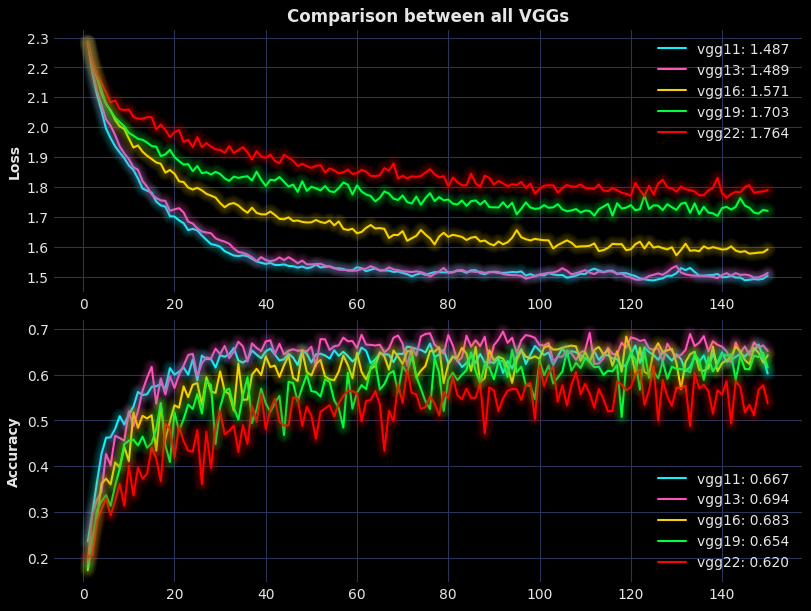

In [6]:
title = 'Comparison between all VGGs'
plot_loss_and_accuracy(title, PARAMS.epochs, loss_dict, acc_dict, 'VGGComparison');

Larger models take longer to train simply because they have more parameters to propagate through

We also observe degradation for VGG19 and VGG22